## Inferencia con modelos

Acá se levantan los modelos entrenados (están en un `.gitignore` porque pesan mucho) y se usan para inferir, igual les voy a hacer un `.py` con funciones para que lo usen.

In [1]:
import random
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import cv2
import os

from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm

In [2]:
# Esto es para no tener que agregar un ../../.. cada vez que quiero acceder a algo en el proyecto

project_root = Path.cwd().parent.parent.parent
os.chdir(project_root)
print("Working directory changed to:", Path.cwd())

Working directory changed to: /home/valen/tp-furbo


In [3]:
MODEL_PATH = Path("runs/detect/train4/weights/best.pt")
BALL_MODEL_PATH = Path("runs/ball/weights/best.pt")

VAL_IMAGES_DIR = Path("data/tracking/YOLO_baseline/images/val")
VIDEO_OUT_DIR = Path("videos")


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda


Loaded model from: runs/detect/train4/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball', 3: 'goalkeeper'}


In [5]:
img_path = random.choice(list(Path(VAL_IMAGES_DIR).glob("*.jpg")))

frame = cv2.imread(str(img_path))

print("Inference on:", img_path.name)

Inference on: SNMOT-160_000288.jpg


## Modelo baseline

Es el que se va a usar sólo para los jugadores y el referee.

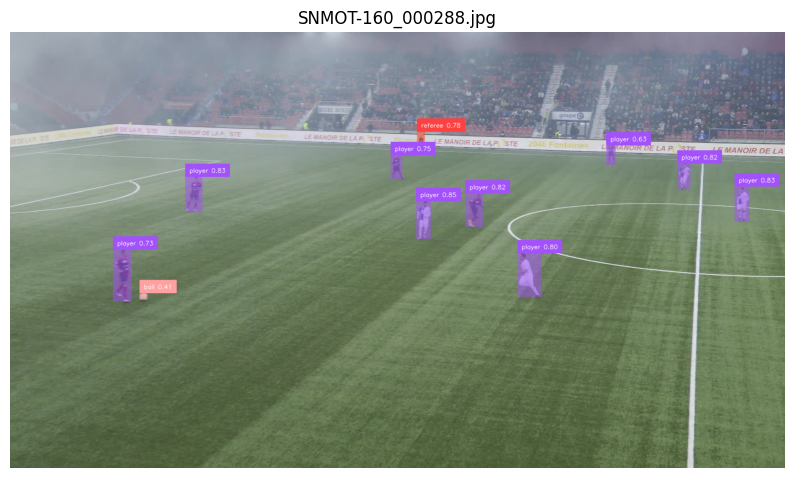

In [6]:
result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=frame.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

## Pelota

Acá se complica más porque la inferencia se divide en 4 parches, igual es sólo importar una librería. 

In [7]:
ball_model = YOLO(str(BALL_MODEL_PATH))

print("Modelo de pelota cargado desde:", BALL_MODEL_PATH)

Modelo de pelota cargado desde: runs/ball/weights/best.pt


In [8]:
def ball_callback(patch: np.ndarray) -> sv.Detections:
    """
    patch: imagen en formato np.ndarray (BGR o RGB; YOLO se adapta).
    Devuelve detecciones de pelota en este patch.
    """
    results = ball_model(patch, conf=0.1, verbose=False)[0]
    
    detections = sv.Detections.from_ultralytics(results)
    return detections


In [9]:
h, w, _ = frame.shape
print(f"Tamaño del frame: {w}x{h}")

slicer = sv.InferenceSlicer(
    callback=ball_callback,
    overlap_filter=sv.OverlapFilter.NON_MAX_SUPPRESSION,
    slice_wh=(w // 2 + 100, h // 2 + 100),  # tamaño de cada slice
    overlap_wh=(100, 100),                  # solapamiento entre slices
    iou_threshold=0.1,
)

print("InferenceSlicer creado.")


Tamaño del frame: 1920x1080
InferenceSlicer creado.


In [10]:
detections_ball = slicer(frame)

print("Detecciones totales:", len(detections_ball))

if len(detections_ball) > 0:
    print("Confianzas (primeras 10):", detections_ball.confidence[:10])
    print("Clases detectadas (únicas):", set(detections_ball.class_id.tolist()))


Detecciones totales: 1
Confianzas (primeras 10): [     0.5097]
Clases detectadas (únicas): {0}


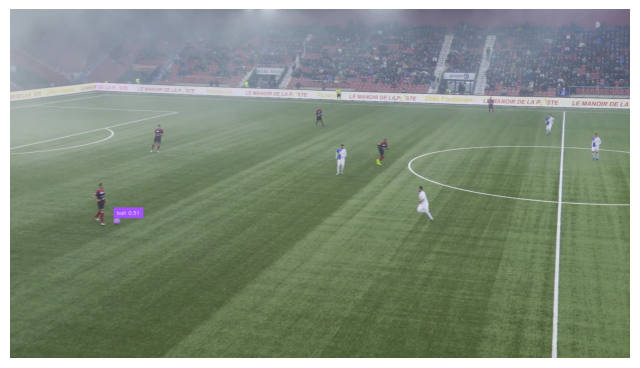

In [ ]:
annotated_frame = color_annotator.annotate(
    scene=frame.copy(),
    detections=detections_ball
)

# Etiquetas: pelota + score
labels = [f"ball {c:.2f}" for c in detections_ball.confidence]

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections_ball,
    labels=labels,
)

annotated_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.show()
